In [1]:
import math
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy import asarray
from pandas import DataFrame
from numpy import concatenate, asarray
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

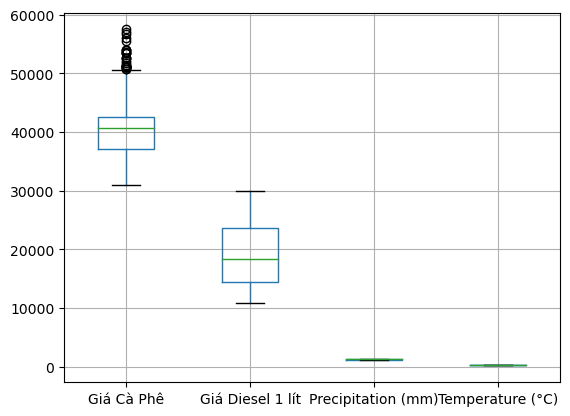

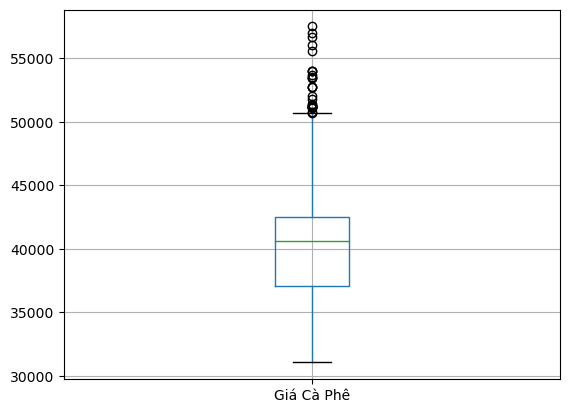

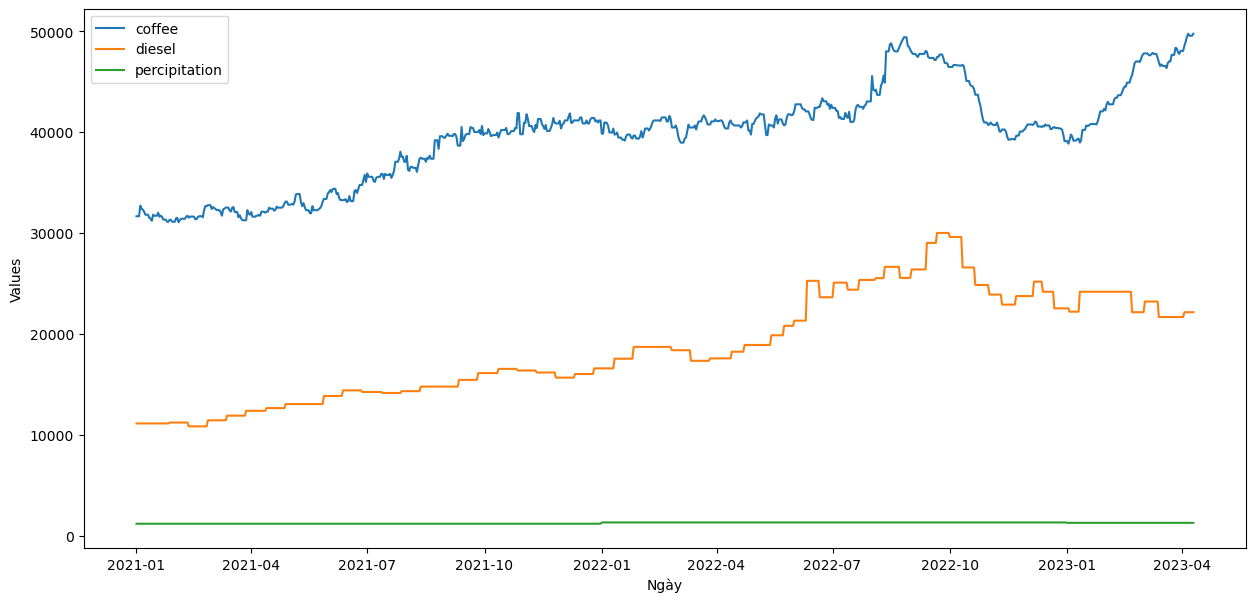

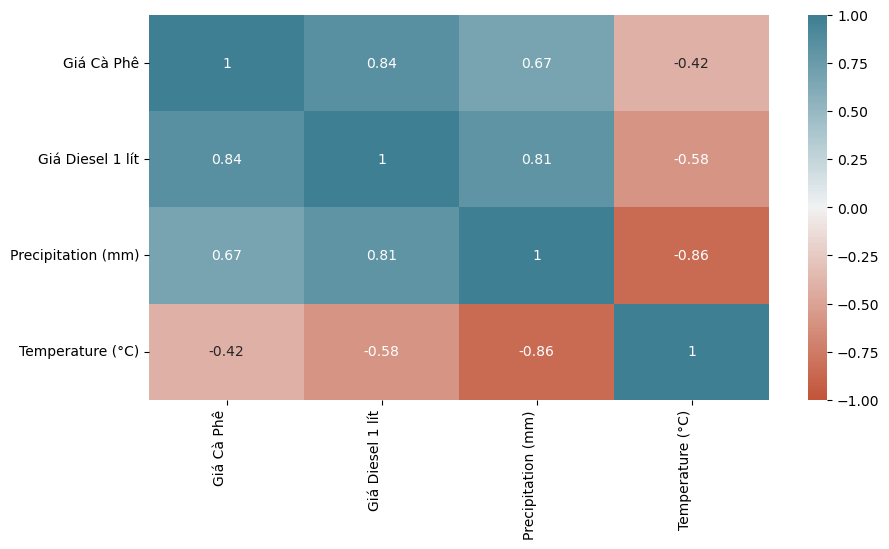

Stored 'data' (DataFrame)


In [2]:
# run data file
%run Data.ipynb

# retreive dataset
%store -r data

# remove date column
data = data.drop(data.columns[[0]], axis = 1)

# reframe
reframed = series_to_supervised(data.values)

In [3]:
# calculate total column to keep
data_column = len(data.columns)
keep_column = look_back * data_column
var_index = (look_back * data_column) + ((predict_ahead - 1) * data_column)

# drop unnecessary columns
reframed = reframed.drop(reframed.iloc[:, keep_column:var_index], axis = 1) 
index_drop = (data_column - 1 ) * -1
reframed = reframed.drop(columns=reframed.columns[index_drop:], axis = 1)

In [4]:
reframed

,var1(t-60),var2(t-60),var3(t-60),var4(t-60),var1(t-59),var2(t-59),var3(t-59),var4(t-59),var1(t-58),var2(t-58),...,var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t+29)
60,31667.5,11120.0,1174.199994,217.0,31667.5,11120.0,1174.199994,217.0,31667.5,11120.0,...,217.0,32767.00,11430.0,1174.199994,217.0,32388.75,11430.0,1174.199994,217.0,31817.0
61,31667.5,11120.0,1174.199994,217.0,31667.5,11120.0,1174.199994,217.0,32717.0,11120.0,...,217.0,32388.75,11430.0,1174.199994,217.0,32575.00,11430.0,1174.199994,217.0,32081.5
62,31667.5,11120.0,1174.199994,217.0,32717.0,11120.0,1174.199994,217.0,32417.0,11120.0,...,217.0,32575.00,11430.0,1174.199994,217.0,32475.00,11430.0,1174.199994,217.0,31617.0
63,32717.0,11120.0,1174.199994,217.0,32417.0,11120.0,1174.199994,217.0,32317.0,11120.0,...,217.0,32475.00,11430.0,1174.199994,217.0,32375.00,11430.0,1174.199994,217.0,31617.0
64,32417.0,11120.0,1174.199994,217.0,32317.0,11120.0,1174.199994,217.0,32117.0,11120.0,...,217.0,32375.00,11430.0,1174.199994,217.0,32275.00,11430.0,1174.199994,217.0,31617.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,39166.5,22200.0,1259.800013,218.0,39166.5,22200.0,1259.800013,218.0,39316.5,22200.0,...,218.0,47666.50,23210.0,1259.800013,218.0,47616.50,23210.0,1259.800013,218.0,49766.5
796,39166.5,22200.0,1259.800013,218.0,39316.5,22200.0,1259.800013,218.0,39366.5,22200.0,...,218.0,47616.50,23210.0,1259.800013,218.0,47716.50,23210.0,1259.800013,218.0,49566.5
797,39316.5,22200.0,1259.800013,218.0,39366.5,22200.0,1259.800013,218.0,38966.5,24180.0,...,218.0,47716.50,23210.0,1259.800013,218.0,47866.50,23210.0,1259.800013,218.0,49566.5
798,39366.5,22200.0,1259.800013,218.0,38966.5,24180.0,1259.800013,218.0,39216.5,24180.0,...,218.0,47866.50,23210.0,1259.800013,218.0,47766.50,23210.0,1259.800013,218.0,49566.5


# Scaling

In [5]:
X = reframed.iloc[:, : -1]
y = reframed.iloc[:, -1:]

In [6]:
scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)
scaled_y = scaler.fit_transform(y)

scaled_X.shape

(740, 240)

# Train

In [7]:
# split
train_X, test_X, train_y, test_y = train_test_split(scaled_X, scaled_y, test_size=0.2, random_state=0)

In [8]:
# create regressor object
regressor = RandomForestRegressor(n_estimators=1000, random_state=0, verbose=0)
 
# fit the regressor with x and y data
history = regressor.fit(train_X, train_y.ravel())

# Result Analysis

In [9]:
# predict
test_pred = (regressor.predict(test_X))

In [10]:
# reshape
test_pred = test_pred.reshape((test_pred.shape[0], 1))

# invert scaling for forecast
inv_test_pred = concatenate((test_pred, test_X), axis=1)
inv_test_pred = scaler.inverse_transform(inv_test_pred)
inv_test_pred = inv_test_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [11]:
print_metrics(inv_y, inv_test_pred)

RMSE: 561.84 (đồng)

MAE: 341.89 (đồng)

MAPE: 0.01

MASE: 0.08


# Predict